### Introduction

The goal of this notebook is to introduce some basic concepts of Machine Learning within the context of (computational chemistry). We will focus on a specific dataset from Therapeutic Data Commons (TDC; https://tdcommons.ai), and we will make use of RDKit to featurize our data points and scikit-learn to design our models. 

In [1]:
import pandas as pd #data manipulation
from tqdm.auto import tqdm #progress bar
from rdkit import Chem #Chemistry
from rdkit.Chem import rdMolDescriptors #molecular descriptors
import numpy as np #matrix algebra
from sklearn.model_selection import train_test_split #ML training
from sklearn.metrics import r2_score, mean_squared_error #ML stats
import seaborn as sns #Plotting
from tdc.single_pred import ADME
import matplotlib.pyplot as plt

from rdkit import rdBase
from rdkit import RDLogger

# Suppress RDKit warnings
rdBase.DisableLog('rdApp.*')
RDLogger.DisableLog('rdApp.*')

In [2]:
sns.set_context('talk')
tqdm.pandas()

### Data Analysis

A good starting point of any machine learning study is to start by analyzing your dataset. Here, we will load a fully curated dataset from TDC, hence no particular data cleaning steps (e.g., filtering out incorrect data points) will be needed -- note that this is usually essential when you generate a dataset from scratch!

In [3]:
data = ADME(name = 'Solubility_AqSolDB')
sol_df = data.get_data()
sol_df.columns = ["Name","SMILES","LogS"]

Found local copy...
Loading...
Done!


In [4]:
print(len(sol_df))

9982


Since the dataset has already been cleaned before we will only generate a distribution of the labels, i.e., the LogS values -- as you can see in the histogram below, there is only one slight outlier.

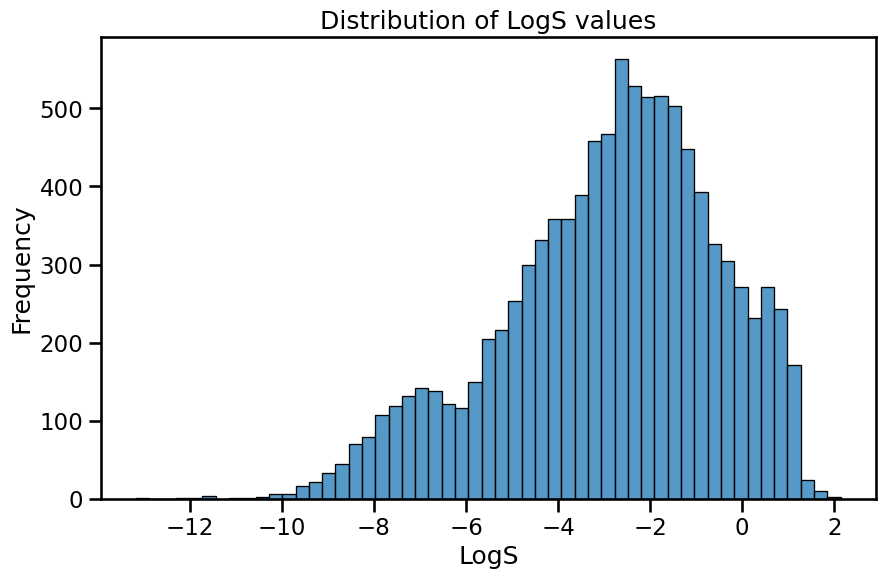

In [5]:
# Initialize the figure
plt.figure(figsize=(10, 6))

# Create the histogram
sns.histplot(sol_df['LogS'], kde=False)

# Customize the plot (optional)
plt.title('Distribution of LogS values')
plt.xlabel('LogS')
plt.ylabel('Frequency')

# Show the plot
plt.show()

### Featurization -- Fingerprints vs. descriptor representation

In the loaded dataset, the datapoints are represented by SMILES strings. If we want to build a machine learning model, we need to generate a mathematical/vectorized description of the datapoint, i.e., we need to generate a representation/featurization.

Several strategies can be taken to featurize molecules based on SMILES input. We will first focus on molecular fingerprints (if you have no idea what fingerprints are, you can take a look here: https://open-babel.readthedocs.io/en/latest/Fingerprints/intro.html#:~:text=Molecular%20fingerprints%20are%20a%20way,particular%20substructures%20in%20the%20molecule.)

In [6]:
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
import rdkit

mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)

def get_fingerprint(smiles, generator=mfpgen):
    mol = Chem.MolFromSmiles(smiles)
    return np.array(generator.GetFingerprint(mol))

In [7]:
sol_df['fingerprint'] = sol_df['SMILES'].progress_apply(lambda x: get_fingerprint(x))

  0%|          | 0/9982 [00:00<?, ?it/s]

Let's build a first simplistic machine learning model with this featurization, a random forest (don't pay too much attention to the parameters used to set up the model for now). We start by splitting the data in a train and test set.

In [8]:
train, test = train_test_split(sol_df, random_state=42)

train_X = np.vstack(train['fingerprint'])
train_y = train.LogS
test_X = np.vstack(test['fingerprint'])
test_y = test.LogS

In [9]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_depth=10, n_estimators=100, max_features=0.2, random_state=42)
# train the model
rf.fit(train_X, train_y)
# predict
pred = rf.predict(test_X)

[Text(0, 0.5, 'Predicted LogS')]

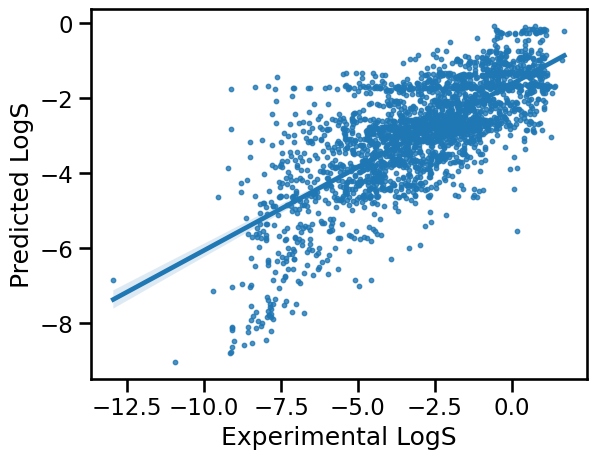

In [10]:
ax = sns.regplot(x=test_y,y=pred,scatter_kws={'s':10})
ax.set(xlabel="Experimental LogS")
ax.set(ylabel="Predicted LogS")

Let's calculate some metrics.

In [11]:
print(r2_score(test_y,pred))
print(mean_squared_error(test_y,pred,squared=False))

0.5191326545869734
1.6204594163143993


Now, we will turn to a common alternative representation of fingerprints, one that is not based on a one-hot encoding of substructure patterns. Often, molecules (or reactions) are represented with the help of computed descriptors. Computed descriptors are typically determined with the help of electronic structure methods, e.g.,  wavefunction approaches, DFT or xTB (e.g., partial charges, orbital coefficients, steric descriptors). Because of the size of our dataset, as well as time- and resource-constraints, we will make use of a simpler method to compute descriptors, i.e., we will extract the built-in descriptors from RDKit, which are computed rapidly since they don't require solving the Schrödinger equation.

In [12]:
# we start by extracting a list of available descriptors from rdkit and we define a function to compute them all at once
property_names = list(rdMolDescriptors.Properties.GetAvailableProperties())
property_getter = rdMolDescriptors.Properties(property_names)

def smi2props(smi):
    mol = Chem.MolFromSmiles(smi)
    props = None
    if mol:
        #Chem.DeleteSubstructs(mol, Chem.MolFromSmarts("[#1X0]"))
        props = np.array(property_getter.ComputeProperties(mol))
    return props

In [13]:
sol_df['props'] = sol_df.SMILES.progress_apply(smi2props)

  0%|          | 0/9982 [00:00<?, ?it/s]

In [14]:
sol_df[property_names] = sol_df['props'].to_list()
train, test = train_test_split(sol_df, random_state=42)

In [15]:
train_X = train[property_names]
train_y = train.LogS
test_X = test[property_names]
test_y = test.LogS

In [16]:
rf2 = RandomForestRegressor(max_depth=10, n_estimators=100, max_features=0.2, random_state=42)
# train the model
rf2.fit(train_X, train_y)
# predict
pred = rf2.predict(test_X)

[Text(0, 0.5, 'Predicted LogS')]

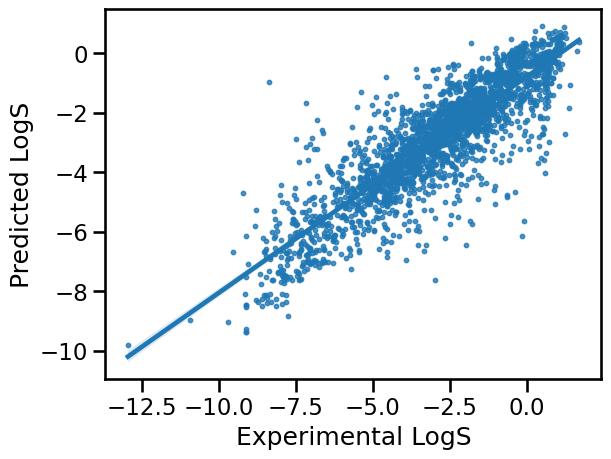

In [17]:
ax = sns.regplot(x=test_y,y=pred,scatter_kws={'s':10})
ax.set(xlabel="Experimental LogS")
ax.set(ylabel="Predicted LogS")

In [18]:
print(r2_score(test_y,pred))
print(mean_squared_error(test_y,pred,squared=False))

0.7628098154823576
1.1380828323732437


### Cross-validation

So, it appear that on the tested train-test split, the constructed descriptor model outperforms by far the fingerprint model, but is this always the case? Are we certain that changing the make-up of train and test set doesn't change this conclusion? 

These questions bring us to the broader question of how we compare model performances. A robust approach to compare models is cross-validation (https://scikit-learn.org/stable/modules/cross_validation.html), where the dataset is split many different times, so that every data-point ends up in the test set once. Below, we will perform a cross-validation for both model architectures introduced so far (this can take a couple of minutes).

In [19]:
from sklearn.model_selection import cross_validate

X = np.vstack(sol_df['fingerprint'])
y = sol_df.LogS

cv_results = cross_validate(rf, X, y, cv=5, scoring=('r2', 'neg_mean_squared_error'))

In [20]:
print(sorted(cv_results.keys()))
print(cv_results['test_r2'])
print(cv_results['test_neg_mean_squared_error'])
mean_error_across_folds = - sum(cv_results['test_neg_mean_squared_error']) / len(cv_results['test_neg_mean_squared_error'])
print(f'The mean error across the folds is: {mean_error_across_folds}')

['fit_time', 'score_time', 'test_neg_mean_squared_error', 'test_r2']
[0.14938163 0.3237068  0.46792602 0.62318669 0.50057186]
[-4.31701604 -5.51625135 -2.41611392 -1.92231853 -1.88905219]
The mean error across the folds is: 3.2121504065463844


The accuracy of our model appears very split-dependent, and the result we obtained for the original split appears to have been unrealistically optimistic. We now do the same for the descriptor-representation.

In [21]:
X2 = np.vstack(sol_df['props'])
y = sol_df.LogS

cv_results_desc = cross_validate(rf, X2, y, cv=5, scoring=('r2', 'neg_mean_squared_error'))

In [22]:
print(cv_results_desc['test_r2'])
print(cv_results_desc['test_neg_mean_squared_error'])
mean_error_across_folds = - sum(cv_results_desc['test_neg_mean_squared_error']) / len(cv_results_desc['test_neg_mean_squared_error'])
print(f'The mean error across the folds is: {mean_error_across_folds}')

[0.54513786 0.63767441 0.78560675 0.85994133 0.71769709]
[-2.30849372 -2.95534398 -0.97354604 -0.71451134 -1.06779111]
The mean error across the folds is: 1.6039372377905863


Note that the accuracy is now much more consistent.

So, the fingerprint model appears to work significantly better. As such, we will focus on this representation in the remainder of this Notebook.

What we still haven't touched upon is the selection of the parameters during the setup of our Random Forest (see above). These parameters are called the hyperparameters of the model, and they greatly affect the performance that the trained model can reach. Fine-tuning them directly to minimize the test error is not a good idea, since this creates a risk for overfitting. To avoid this, we typically determine the hyperparameters exclusively based on the test-set. This ensures no data leakage takes, resulting in overfitting, takes place.

In [23]:
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

train, test = train_test_split(sol_df, random_state=42)
train_X = np.vstack(train['props'])
train_y = train.LogS
test_X = np.vstack(test['props'])
test_y = test.LogS

hyper_cv = KFold(n_splits=4, shuffle=True, random_state=42)

Now we will run a grid search of various combinations of hyperparameters.

In [24]:
# Set up possible values of the hyperparameters to optimize over
p_grid = {"max_depth": [25, 50, 75], "n_estimators": [100, 200, 300], "max_features": [0.2, 0.5, 1]}

In [25]:
rf3 = RandomForestRegressor(random_state=42)
hyper_search = GridSearchCV(estimator=rf3, param_grid=p_grid, cv=hyper_cv)
hyper_search.fit(train_X, train_y)

GridSearchCV(cv=KFold(n_splits=4, random_state=42, shuffle=True),
             estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [25, 50, 75],
                         'max_features': [0.2, 0.5, 1],
                         'n_estimators': [100, 200, 300]})

In [26]:
print(hyper_search.best_score_)
print(hyper_search.best_estimator_)
print(hyper_search.best_params_)

0.7714709306098528
RandomForestRegressor(max_depth=50, max_features=0.5, n_estimators=200,
                      random_state=42)
{'max_depth': 50, 'max_features': 0.5, 'n_estimators': 200}


We set the hyperparameters to the optimal ones emerging from our grid search. To get a sense about how well our model will perform on unseen data points, we can apply our model to the (unseen) test set.

In [27]:
rf_final = RandomForestRegressor(max_depth=hyper_search.best_params_['max_depth'], max_features=hyper_search.best_params_['max_features'], 
                                 n_estimators=hyper_search.best_params_['n_estimators'], random_state=42)
rf_final.fit(train_X, train_y)

pred = rf_final.predict(test_X)

[Text(0, 0.5, 'Predicted LogS')]

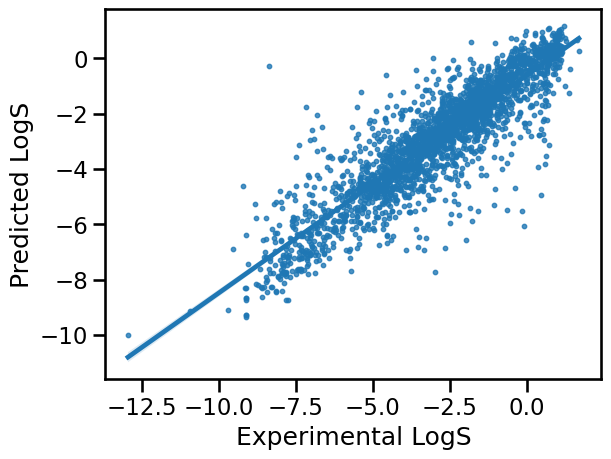

In [28]:
ax = sns.regplot(x=test_y,y=pred,scatter_kws={'s':10})
ax.set(xlabel="Experimental LogS")
ax.set(ylabel="Predicted LogS")

In [29]:
print(r2_score(test_y,pred))
print(mean_squared_error(test_y,pred,squared=False))

0.7896177342350702
1.071840294420832


So, we obtain a slight improvement over the performance with the original, non-fine-tuned, hyperparameters. It should be noted that once again, we only evaluated 1 split here; in practice we will often perform a so-called "nested cross-validation" to evaluate and compare the performance of different model architectures across hyperparameter settings (cf. https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/).